In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from pldflow import plflow

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tutorial 1
In this tutorial, I explain how to use the PL flow model.

### Problem definition/notation
Our problem is to evaluate the following integral involving the oscillating integrand.
$$
Z = \int {\rm d} x e^{-S(x)}
$$
where $x$ is a rela number $n$-dimensional integral variable $x\in\mathcal{R}^n$, and $S(x)$ is the action which is usually a complex function.

Using the PL theory, we analytically continuate the integral $x\rightarrow z \in \mathcal{C}^n$, and now the integral
$$
Z = \int_{\Gamma} {\rm d} z e^{-S(z)}
$$
is performed over a path $\Gamma$ in $\mathcal{C}^n$ space. Note that the path is a subspace with degree-of-freedom $n$ in $\mathcal{C}^n$ space, because the original path before analytic continuation is $x\in\mathcal{R}^n$.

The nice path over which the integrand does not oscilate so much can be found by solving the PL flow equation
$$
\frac{{\rm d}z}{{\rm d}\tau} = \overline{\frac{\partial S(z)}{\partial z}}
$$
with initial condition $z(\tau=0)=x$. We can show that the action monotonically increase
$$
\frac{{\rm d}S}{{\rm d}\tau} = \frac{\partial S}{\partial z} \cdot \frac{\partial z}{\partial \tau} = \left|\frac{\partial S}{\partial z}\right|^2 \geq0
$$
making the amplitude value of the integrand smaller as flow evolves. Practically we stop the flow at some finite flow time $\tau$.

The solution of the PL flow can be interpreted as the mapping between the initial position $x$ and the last position $z=z(x)$. Using this relation we transform the integral back into the integral over the real variable.

$$
Z = \int {\rm d} x \det\left(\frac{\partial z}{\partial x}\right) e^{-S(z(x))}
$$

In this notebook, we explain how to define the problem and how to solve the PL flow.

### `PicardLefschetzModelBaseClass` class
As a working example, we use the Frensel integral in n=1 dimension.
$$
S(x) = ix^2 + i2xy
$$
with a extra parameter $y$.

`plflow.PicardLefschetzModelBaseClass` is the base class you can inherit to define your own problem.

In [4]:
class Fresnel(plflow.PicardLefschetzModelBaseClass):
    # Here the ndim is the dimension of x. 
    ndim = 1
    def action_s(self, z, y):
        zz = jnp.dot(z,z)
        # In this particular example, we use the additional `y`
        # in the same dimension as `z`, so we use `jnp.dot(z,y)`
        zy = jnp.dot(z,y) 
        return 1j * (zz + 2*zy)

In [5]:
# instantiate the model
fresnel = Fresnel()

The base class has various functions you can use.
- `grad_s`: partial derivative of the action with respect to the input.
- `integrand`: the integrand $I(z)=e^{-S(z)}$
- `velocity`: the velocity on the right hand side of the PL flow eq, i.e. the complex conjugate of the partial derivative of the action.
- `flow`: sovle the flow equation with the Euler integration algorithm for a given initial point $x$ and flow time $\tau$ which is given as an array of time steps.
- `flow_jacobian`: the jacobian between $z$ and $x$ at the flow time $\tau$.

These function accepts one n-dimensional variable $z$ or $x$. 

If you want to do the same things for multiple n-dimenional variable, use the corresponding function with a prefix of `v`.
For example if you want to evaluate the integrand over multiple $z$ values, then use `vintegrand` function.

For example, if you want to get the integrand on a complex number or some of complex numbers,

In [6]:
z = jnp.array([0.0]) # one n-dimensional variable
y = jnp.array([0.0])
i = fresnel.integrand(z, y=y)
print(i)

(1-0j)


In [7]:
z = jnp.linspace(-1,1,100).reshape(100,1) # m=100 n-dimensional variable
y = jnp.array([0.0])
i = fresnel.vintegrand(z, y=y) # m values of integrand
print(i.shape)

(100,)


To sovle the flow equation, 

In [8]:
t = jnp.linspace(0, 1, 10)
x = jnp.array([0.0])
y = jnp.array([0.0])
z = fresnel.flow(x, t=t, y=y) # m values of action
print(z)

[0.+0.j]


In [9]:
t = jnp.linspace(0, 1, 10)
x = jnp.linspace(-1,1,100).reshape(100, -1)
y = jnp.array([0.0])
z = fresnel.vflow(x, t=t, y=y) # m values of action
print(z.shape)

(100, 1)


By default, `flow` function returns the `z` at the last time in the `t` array (this case tau=0.2), but if you want to get `z` values at all `t` time, then turn off the `uselast=False` flag off.

In [10]:
t = jnp.linspace(0, 1, 10)
x = jnp.linspace(-1,1,100).reshape(100, -1)
y = jnp.array([0.0])
z = fresnel.vflow(x, t=t, y=y, uselast=False) # m values of action
print(z.shape) # with shape (number of z points, number of t points, ndim)

(100, 10, 1)


You can easily make a plot showing how the x maps into z.

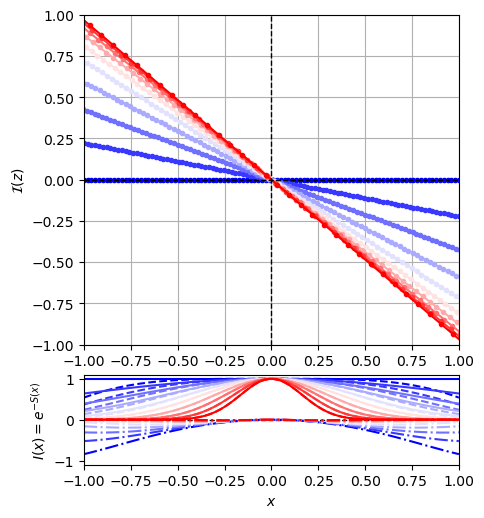

In [11]:
t = jnp.linspace(0, 1, 10)
x = jnp.linspace(-1,1,100).reshape(100, -1)
y = jnp.array([0.0])

# By default, this plots z(t) at all t values
fig, axes = fresnel.plot1d(x, t=t, y=y)

# If you want to show z(t) for some particular index of t array, then use `t_indices`
# fig, axes = fresnel.plot1d(x, t=t, y=y, t_indices=[0,3,6,9])

You can also make a gif file

In [12]:
t = jnp.linspace(0, 1, 10)
x = jnp.linspace(-1,1,100).reshape(100, -1)
y = jnp.array([0.0])

saveto = 'fresnel.gif'
# fresnel.plot1dgif(saveto, x, t=t, y=y)

This may be more informative:
showing the color plot of the action over 2D (Re(z), Im(z)) space.

In [13]:
t = jnp.linspace(0, 1, 10)
x = jnp.linspace(-1,1,100).reshape(100, -1)
y = jnp.array([0.0])

grid_size = 100
saveto = 'fresnel.gif'

# fig, axes = fresnel._plot1d_template()
# fresnel.plot1d_action_map(grid_size, y=y, fig=fig, axes=axes, shading='auto')
# fresnel.plot1dgif(saveto, x, t=t, y=y, w=w, fig=fig, axes=axes, dpi=150)
# plt.show()

### Performing the integral
For 1D problem, we can perform the integral easily. Let's do it here.

In [14]:
t = jnp.linspace(0, 1, 10)
x = jnp.linspace(-1,1,100).reshape(100, -1)
y = jnp.array([0.0])

# 1. find the mapped z
z = fresnel.vflow(x, t=t, y=y)
# 2. get the integrand on z
i = fresnel.vintegrand(z, y=y)
# 3. also get the jacobian
j = fresnel.vflow_jacobian(x, t=t, y=y)

Z = jnp.trapezoid(i*j, x[:,0], axis=0)
Z_true = jnp.sqrt(jnp.pi) * jnp.exp(-1j*jnp.pi/4)

print(f'Numerical = {Z}, True = {Z_true}')

Numerical = (1.2533140182495117-1.2533142566680908j), True = (1.2533141374588013-1.2533141374588013j)


Let's also see the y dependence. Note this implementation is not optimal (naive loop over y)

In [15]:
%%time
y = jnp.linspace(-2,2,100).reshape(100, -1)
Z = []

for _y in y:
    t = jnp.linspace(0, 1, 10)
    x = jnp.linspace(-5,5,1000).reshape(1000, -1)

    # 1. find the mapped z
    z = fresnel.vflow(x, t=t, y=_y)
    # 2. get the integrand on z
    i = fresnel.vintegrand(z, y=_y)
    # 3. also get the jacobian
    j = fresnel.vflow_jacobian(x, t=t, y=_y)

    _Z = jnp.trapezoid(i*j, x[:,0], axis=0)
    Z.append(_Z)

Z = jnp.array(Z)
Z_true = jnp.sqrt(jnp.pi) * jnp.exp(-1j*jnp.pi/4) * jnp.exp(1j*y**2)

CPU times: user 2.62 s, sys: 154 ms, total: 2.77 s
Wall time: 2.13 s


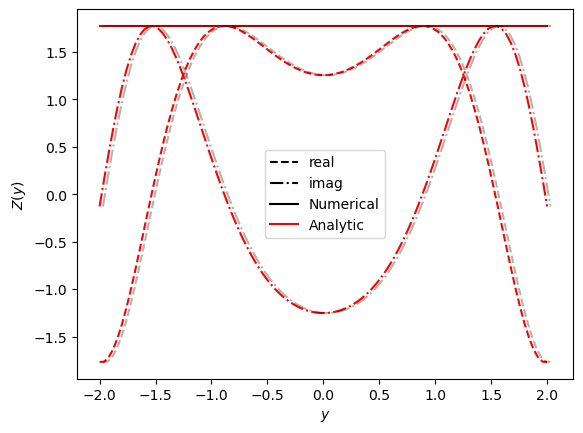

In [17]:
# Numerical solution
plt.plot(y, jnp.real(Z), 'r', ls='--')
plt.plot(y, jnp.imag(Z), 'r', ls='-.')
plt.plot(y, jnp.abs(Z) , 'r', ls='-')
# True solution
dy = 0.03 # shift y to avoid perfect overlapping
plt.plot(y+dy, jnp.real(Z_true), 'k', ls='--', alpha=0.3)
plt.plot(y+dy, jnp.imag(Z_true), 'k', ls='-.', alpha=0.3)
plt.plot(y+dy, jnp.abs(Z_true) , 'k', ls='-' , alpha=0.3)
# legends
plt.plot(jnp.nan, color='k', ls='--', label='real')
plt.plot(jnp.nan, color='k', ls='-.', label='imag')
plt.plot(jnp.nan, color='k', ls='-' , label='Numerical')
plt.plot(jnp.nan, color='r', ls='-' , label='Analytic')
plt.legend()
# label
plt.xlabel(r'$y$')
plt.ylabel(r'$Z(y)$')
plt.show()